# Vibration Data Analysis

### Industrial pump

The object of this notebook is the visualisation and analysis of vibration data aquired from a sensor monitoring an industrial pump.  


In [375]:
%matplotlib inline
from __future__ import print_function # for Python 2.7 compatibility
from IPython.display import display, HTML

import operator
import math
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import scipy.signal as sg

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from math import floor, log

In [343]:
# Load the csv data
df = pd.read_csv('./Input_data/DataSet/project_pump.csv', header=None, sep="[;]")

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [344]:
# Convert the measures loaded as string in the last column as list of float
df[4] = df[4].apply(lambda x : map(float,x.strip("[]").split(", ")))

# Convert the timestamps into ms elapsed since the origin
df[0] = df[0].apply(lambda x : x-df[0][0])

#Verify that there is no null data in the set
df.isnull().any().sum()

0

In [345]:
# Sampling rate
print('Min sampling rate: {}'.format(min(df[3])))

Min sampling rate: 48046.9208211


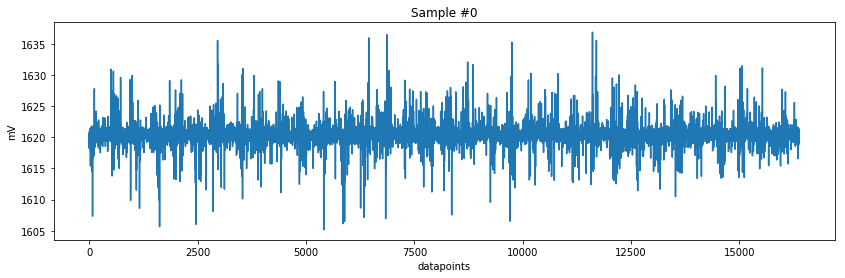

In [346]:
# Plot the first sample data
ind = 0
plt.figure(figsize=(14, 4))
plt.plot(df[4][ind])
plt.xlabel('datapoints')
plt.ylabel('mV')
plt.title("Sample #{}".format(ind))
plt.show()

In [347]:
# Display part of the data loaded

def display_pd(some_df):
    display(HTML(some_df.to_html()))
    
display_pd(df.head(5)) # special display to see all columns
print('{} samples'.format(df.shape[0])) # Dimensions of the dataframe

,0,1,2,3,4
0,0.000000,16384,340,48188.235294,"[1618.37768555, 1620.2911377, 1620.19042969, 1..."
1,0.384504,16384,340,48188.235294,"[1618.32733154, 1620.03936768, 1620.2911377, 1..."
2,0.770315,16384,341,48046.920821,"[1619.78759766, 1620.49255371, 1620.03936768, ..."
3,1.151935,16384,340,48188.235294,"[1619.53582764, 1619.58618164, 1619.93865967, ..."
4,1.544111,16384,340,48188.235294,"[1619.13299561, 1619.88830566, 1619.68688965, ..."


882 samples


In [348]:
# Print the total duration of the sample period in min
print('{} min'.format(np.round((df[0].iloc[-1]-df[0].iloc[0])/60,2)))

5.84 min


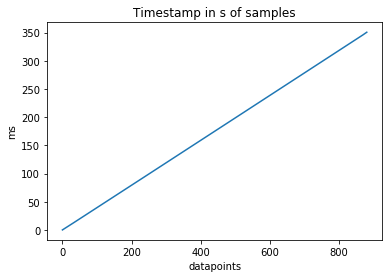

In [349]:
# Plot the time elapsed between samples
plt.plot(list(df[0]))
plt.xlabel('datapoints')
plt.ylabel('ms')
plt.title("Timestamp in s of samples")
plt.show()

The samples are acquired over a total period of 350 s. 

Each sample is about 340 ms long.
There is a small gap between each sampling period of about 50 ms.  

Note: For simplicity and as it does not change the frequency analysis below, this gap will be ignored. Times provided below for events can be corrected to obtain the real time stamps by a factor of 350/300 (total time/sampling time).

In [350]:
# Signal processing functions

def calcFFT(epoch):
    ''' Calculates the FFT of the epoch signal. Removes the DC component.
    '''
    M = len(epoch)
    w = np.kaiser(M, 0.11)
    spectrum = np.fft.fft(w*epoch, axis=0)
    spectrum = np.abs(spectrum)
    spectrum[0]=0 # set the DC component to zero

    return spectrum


def calcWelch(epoch, fs):
    """ Calculate the Power Spectral Density using the Welch method.
    """
    len(epoch)
    f, epoch = sg.welch(epoch, fs)
    return f, epoch


def calcPSD(fft_epoch):
    ''' Calculate the Power Spectral Density.
    '''
    psd = np.power(np.abs(fft_epoch), 2)
    return psd


def calcRMS(epoch):
    """Calculate RMS power level.
    """
    len(epoch)
    epoch = pow(np.abs(epoch),2)
    return math.sqrt ( epoch.mean() )

    
def calcCrestFact(epoch, rms):
    """ Calculate the crest factor (Peak-to-RMS ratio).
    """
    return np.max(np.abs(epoch))/rms
    
    
def real_cepstrum(x, n=None):
    """ Calculate the real part of Cepstrum.
    """
    spectrum = np.fft.fft(x, n=n)
    ceps = np.fft.ifft(np.log(np.abs(spectrum))).real

    return ceps


def complex_cepstrum(x, n=None):
    """ Calculate the Cepstrum.
    """
    def _unwrap(phase):
        samples = phase.shape[-1]
        unwrapped = np.unwrap(phase)
        center = (samples + 1) // 2
        if samples == 1:
            center = 0
        ndelay = np.array(np.round(unwrapped[..., center] / np.pi))
        unwrapped -= np.pi * ndelay[..., None] * np.arange(samples) / center
        return unwrapped, ndelay

    spectrum = np.fft.fft(x, n=n)
    unwrapped_phase, ndelay = _unwrap(np.angle(spectrum))
    log_spectrum = np.log(np.abs(spectrum)) + 1j * unwrapped_phase
    ceps = np.fft.ifft(log_spectrum).real

    return ceps, ndelay


def defineFreqs():
    ''' Frequency bands.
    '''
    return (np.array(range(0,24000,12000)))  # Frequency levels in Hz

Time in s: [ 65 122 182 241], Indices: [192 358 537 710])


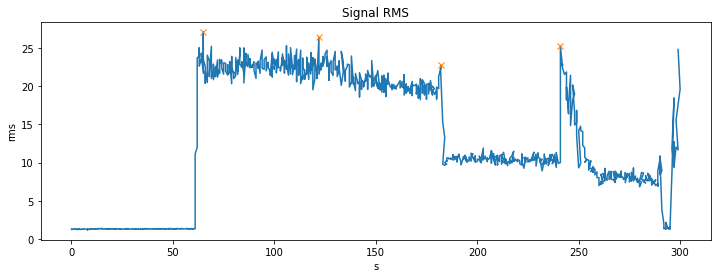

In [351]:
# Plot the RMS of the signal along the recording period
rms = []
crest = []
time = []
for i in range(0,df.shape[0],1):
    epoch = df[4].iloc[i]
    epoch -= baseline # Center the signal to 0
    rms_epoch = calcRMS(epoch)
    rms.append(rms_epoch)
    crest.append(calcCrestFact(epoch, rms[i]))
    time.append(i*df[2].iloc[i]/1000)

    
indexes, _ = sg.find_peaks(rms, height = max(15,np.percentile(rms, 80)), distance=90, prominence=4)   
rms = np.array(rms)
time = np.array(time)
print('Time in s: {}, Indices: {})'.format(time[indexes], indexes))

plt.figure(figsize=(12, 4))
plt.plot(time, rms)
plt.plot(time[indexes],rms[indexes], 'x')
#plt.plot(rms)
plt.title('Signal RMS')
plt.xlabel('s')
plt.ylabel('rms')
plt.show()

Time in s: [ 61 249 295], Indices: [181 735 866])
(Note: The real timestamps for the events are: [  71.  290.  344.])


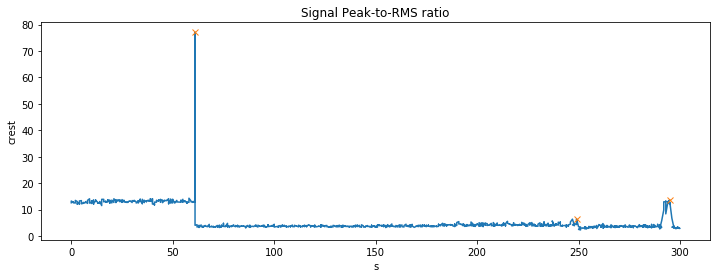

In [352]:
# Plot the Peak-to-RMS ratio
# Find peaks in the Crest ratio
indexes, _ = sg.find_peaks(crest, height = max(2,np.percentile(crest, 70)), distance=10, prominence=3)
plt.figure(figsize=(12, 4))
plt.plot(time, crest)
crest = np.array(crest)
print('Time in s: {}, Indices: {})'.format(time[indexes], indexes))
print('(Note: The real timestamps for the events are: {})'.format(np.round(np.multiply(time[indexes],350./300.),0)))
plt.plot(time[indexes], crest[indexes], 'x')
plt.xlabel('s')
plt.ylabel('crest')
plt.title('Signal Peak-to-RMS ratio')
plt.show()

The pump undergoes some clear state changes at 4 points in times that are visible in the RMS and Peak-to-RMS ratio graphs.

In [353]:
# Compute the mean and variance of each sample
list_var = []
list_mean = []
for i in range(0,df.shape[0]):
    list_var.append(np.var(df[4].iloc[i]))
    list_mean.append(np.mean(df[4].iloc[i]))

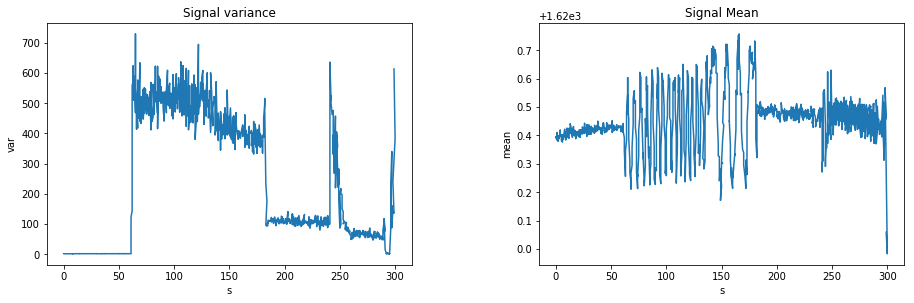

In [354]:
plt.figure(figsize=(14, 4))
plt.subplot(1,2,1)
plt.plot(time,list_var)
plt.xlabel('s')
plt.ylabel('var')
plt.title('Signal variance')
plt.subplot(1,2,2)
plt.plot(time,list_mean)
plt.xlabel('s')
plt.ylabel('mean')
plt.title('Signal Mean')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

We can see on the 2 plots that the pump pass through different phases that match the information given by the Peak-to-RMS ratio.  
The short time span for the measurements, and the controled look of the experiment make these observation more likely due to a change in the conditions than the deterioration of the material.  
We will study more in detail those phases as well as the transition period.

In [355]:
# Compute the constant baseline on the 50 first samples
mean_list = []
for i in range(50):
    mean_list.append(np.mean(df[4].iloc[i]))
baseline = np.mean(mean_list)
print('baseline measure : {} mV'.format(baseline))

baseline measure : 1620.40319121 mV


The first phase of the experiment is very stable .
We use the average of the measure over that period to define the baseline for the sensor.

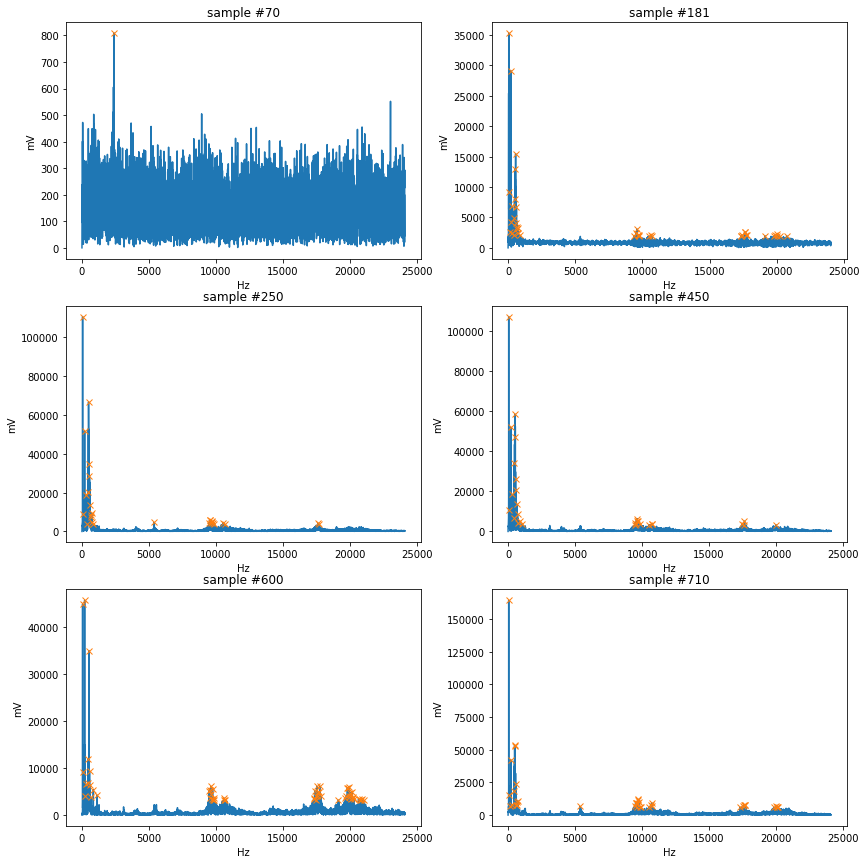

Sample #70, Peaks nb: 1, Peak freq: [ 2385.29]
Sample #181, Peaks nb: 42, Peak freq: [  50.    100.    152.94  200.    232.35  273.53  305.88  411.76]
Sample #250, Peaks nb: 28, Peak freq: [  46.92   99.71  199.41  284.46  401.76  434.02  489.74  524.93]
Sample #450, Peaks nb: 29, Peak freq: [  47.06  100.    200.    288.24  423.53  464.71  494.12  526.47]
Sample #600, Peaks nb: 56, Peak freq: [  47.06  100.    200.    235.29  302.94  423.53  470.59  517.65]
Sample #710, Peaks nb: 38, Peak freq: [  46.92   99.71  167.16  199.41  284.46  457.48  486.8   530.79]


In [356]:
# Spectrum of the signal in 6 samples
plt.figure()
plt.figure(figsize=(14, 20))

# Samples selection
#sample_list = range(0,df.shape[0],int(df.shape[0]/7.9))
sample_list = [70, 181, 250, 450, 600, 710]

count = 0
spect_peaks = [] # Record the spectrum peaks for each sample

for i in sample_list:
    count += 1

    half = int(df[1].iloc[i]/2) # For keeping the spectrum positive frequency components 
    epoch = df[4].iloc[i]
    epoch -= baseline # Center the signal to 0
    
    # Calculate the spectrum
    fft_epoch = calcFFT(epoch)[:half]
    
    # Find peaks on in the spectrum
    indexes, _ = sg.find_peaks(fft_epoch, height = max(800,np.percentile(fft_epoch, 98)), distance=10, prominence=0.9)
    spect_peaks.append(indexes)
    
    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.subplot(4,2,count)
    plt.plot(freq, fft_epoch)
    plt.plot(freq[indexes], fft_epoch[indexes], "x")
    plt.xlabel('Hz')
    plt.ylabel('mV')
    plt.title("sample #"+str(i))

plt.show()
for i in range(len(spect_peaks)):
    half = int(df[1].iloc[i]/2) # For keeping the positive frequency components 
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    peak_i = spect_peaks[i]
    print('Sample #{}, Peaks nb: {}, Peak freq: {}'.format(sample_list[i], len(peak_i), np.round(freq[peak_i[:min(len(peak_i), 8)]],2)))


The signal spectrum gives us some information on the c
As suspected the signal in the first phase does not show much information regarding the system and pobably correspond to noise.
The profile of the spectrum shows a lot if similarity afterwards, with recognizable peaks in the frequency range observed in all the following graphs.

The peak values obtained in the lower ranges are consitant with some
The first frequency 47 Hz correspond probably the pump axis operating at 2820 rpm. 
Other frequencies and harmonics are detected at 100, 200, 400 Hz.

For the sample corresponding to what could be assumed as changes in conditions, the spectrum is indeed spread slightly differently. The intensity of the low frequency peak (50 Hz) is only a third of the intensity when the regime is set.

In the third phase, the comparative intensity of the low frequency peak (47 Hz, 100Hz) is lower than in the previous phase, about less than half.

For the sample recorded after 241 seconds, the intensity of the low frequency peak (47 Hz) is the highest, 1.5 times the level seen in the phase 2. This confirm the hypothesis of a sudden change in the conditions at that moment.

[1619.233703613281, 1620.0393676757812, 1619.1329956054688, 1619.9890136718748, 1619.8883056640625]
[    0.           704.24676997  1327.46803094  1160.13705992  1741.10448117]


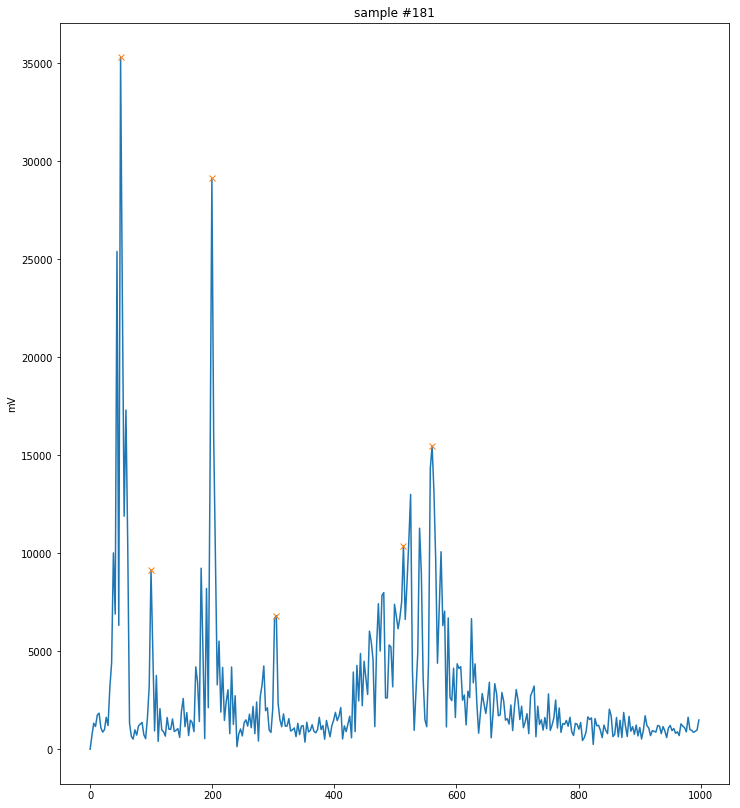

Sample #181, Peaks nb: 6, Peak freq: [  49.85   99.71  199.41  304.99  513.2   560.12]


In [359]:
# Spectrum of the signal in on sample over a frequency range

sample = 181

ind = 0
peaks = []

freq_range = [0, 1000]#[8000, 12500], [3000, 6000], [0, 1000], [17000, 18500], [19000, 22000]
inf = int(freq_range[0]/float((df[3].iloc[sample]/df[1].iloc[sample])))
sup = int(freq_range[1]/float((df[3].iloc[sample]/df[1].iloc[sample])))

for i in [sample]:
    ind += 1

    half = int(df[1].iloc[sample]/2) # For keeping the positive frequency components 
    epoch = df[4].iloc[i]
    print(epoch[:5])
    epoch -= baseline # Center the signal to 0
    
    fft_epoch = calcFFT(epoch)
    print(fft_epoch[:5])
    
    #[0, 1000]
    indexes, _ = sg.find_peaks(fft_epoch[inf:sup], height = max(600,np.percentile(fft_epoch[inf:sup], 89)), distance=15, prominence=0.9)
    #[19000, 22000]
    #indexes, _ = sg.find_peaks(fft_epoch[inf:sup], height = max(600,np.percentile(fft_epoch[inf:sup], 89)), distance=15, prominence=6000)
    #[8000, 12500], [3000, 6000], [17000, 18500]
    #indexes, _ = sg.find_peaks(fft_epoch[inf:sup], height = max(600,np.percentile(fft_epoch[inf:sup], 95)), distance=200, prominence=0.9)
    #indexes, _ = sg.find_peaks(fft_epoch[inf:sup], height = max(600,np.percentile(fft_epoch[inf:sup], 92)), distance=100, prominence=0.9)
    peaks.append(indexes)

    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.figure()
    plt.figure(figsize=(12, 14))
    plt.plot(freq[inf:sup], fft_epoch[inf:sup])
    plt.plot(freq[inf:sup][indexes], fft_epoch[inf:sup][indexes], "x")
    plt.ylabel('mV')
    plt.title("sample #"+str(i))

plt.show()
for i in range(len(peaks)):
    peak_i = peaks[i]
    print('Sample #{}, Peaks nb: {}, Peak freq: {}'.format(sample, len(peak_i), np.round(freq[peak_i[:min(len(peak_i), 8)]]+freq_range[0],2)))


[  3  51  57  94 106]


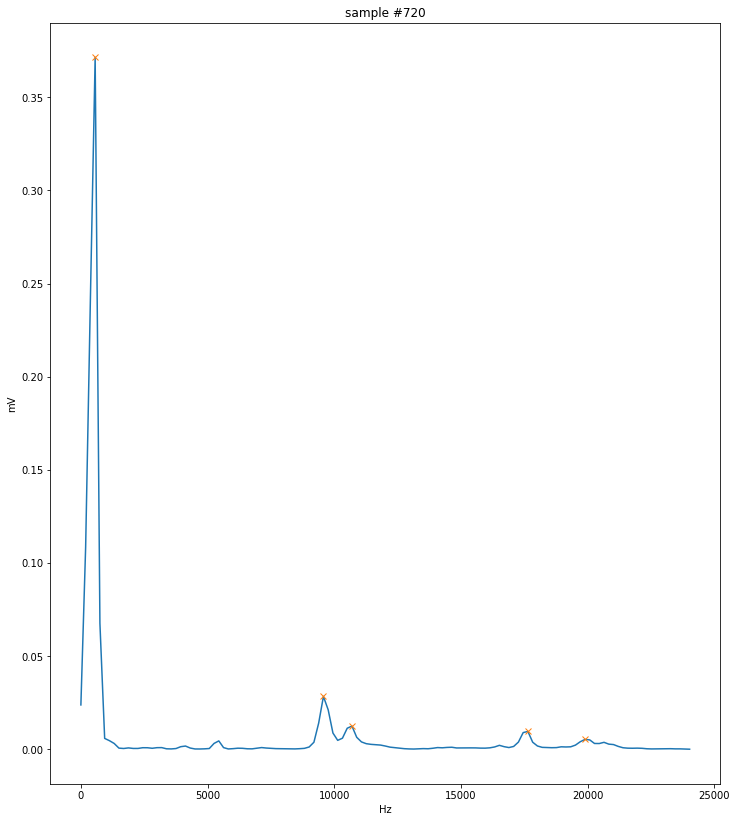

Sample #720, Peaks nb: 5, Peak freq: [   563.05   9571.85  10697.95  17642.23  19894.43]


In [360]:
# Power Spectral Density (Welch method) of the signal in on sample
ind = 0
peaks = []
sample_list = [720]

for i in sample_list:
    ind += 1
    
    half = int(len(df[4].iloc[i])/2) # For keeping the positive frequency components
    epoch = df[4].iloc[i]
    epoch -= baseline # Center the signal to 0
    
    f, psd_epoch = calcWelch(epoch, fs = df[3].iloc[i])
    
    #indexes = sg.find_peaks_cwt(fft_epoch2, np.arange(1, 10), max_distances=np.arange(1, 10)*2)
    #indexes = np.array(indexes) - 1
    indexes, _ = sg.find_peaks(psd_epoch, height = max(0.0001, np.percentile(psd_epoch, 85)))
    print(indexes)
    peaks.append(indexes)
    
    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.figure()
    plt.figure(figsize=(12, 14))
    plt.plot(f, psd_epoch)
    plt.plot(f[indexes], psd_epoch[indexes], "x")
    plt.xlabel('Hz')
    plt.ylabel('mV')
    plt.title("sample #"+str(i))
    
plt.show()
for i in range(len(peaks)):
    peak_i = peaks[i]
    print('Sample #{}, Peaks nb: {}, Peak freq: {}'.format(sample_list[i], len(peak_i), np.round(f[peak_i[:min(len(peak_i), 8)]],2)))

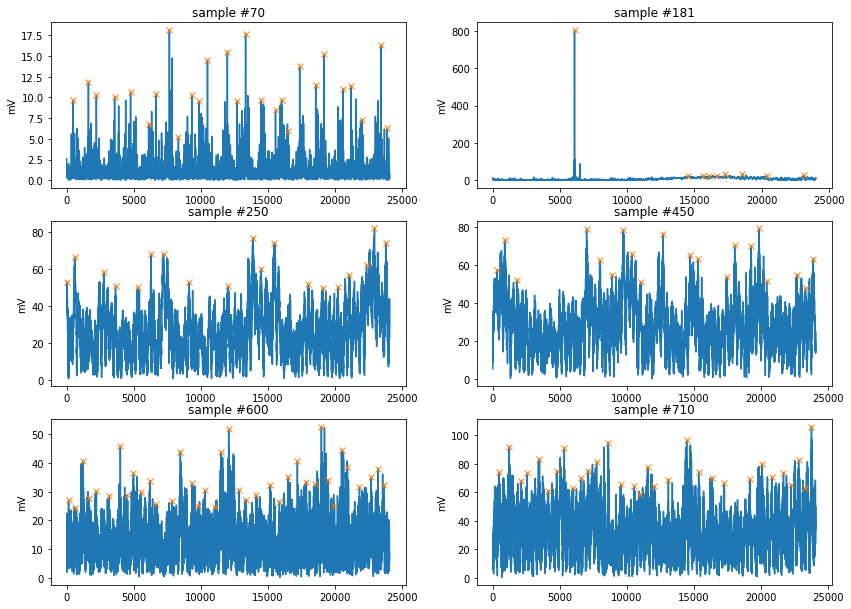

Sample #70, Peaks nb: 27, Peak freq: [  476.47  1620.59  2211.76  3573.53  4764.71  6152.94  6670.59  7661.76]
Sample #181, Peaks nb: 9, Peak freq: [  6097.06  14576.47  15676.47  16135.29  16738.24  17350.    18632.35
  20452.94]
Sample #250, Peaks nb: 19, Peak freq: [  5.88000000e+00   5.91180000e+02   2.75882000e+03   3.64118000e+03
   5.29412000e+03   6.27941000e+03   7.22941000e+03   9.12647000e+03]
Sample #450, Peaks nb: 20, Peak freq: [   335.29    879.41   1823.53   7000.     7985.29   8873.53   9744.12
  10382.35]
Sample #600, Peaks nb: 38, Peak freq: [  138.24   605.88  1208.82  1673.53  2214.71  3170.59  4002.94  4464.71]
Sample #710, Peaks nb: 31, Peak freq: [  470.59  1214.71  2123.53  2570.59  3447.06  4150.    4770.59  5335.29]


In [366]:
# Envelop spectrum (Hilbert method) of the signal in on sample
plt.figure()
plt.figure(figsize=(14, 14))
ind = 0
peaks = []

# Samples selection
#sample_list = range(0,df.shape[0],int(df.shape[0]/7.9))
sample_list = [70, 181, 250, 450, 600, 710]

for i in sample_list:
    ind += 1

    half = int(len(df[4].iloc[i])/2) # For keeping the positive frequency components 
    epoch = df[4].iloc[i]
    epoch -= baseline # Center the signal to 0
    
    analytic_signal = sg.hilbert(epoch)
    amplitude_envelope = np.abs(analytic_signal)
    
    #indexes = sg.find_peaks_cwt(fft_epoch2, np.arange(1, 10), max_distances=np.arange(1, 10)*2)
    #indexes = np.array(indexes) - 1
    indexes, _ = sg.find_peaks(amplitude_envelope[:half], height = max(5,np.percentile(amplitude_envelope, 92)), distance=150, prominence=0.8)
    peaks.append(indexes)
    
    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.subplot(4,2,ind)
    plt.plot(freq, amplitude_envelope[:half])
    plt.plot(freq[indexes], amplitude_envelope[indexes], "x")
    plt.ylabel('mV')
    plt.title("sample #"+str(i))

plt.show()
for i in range(len(peaks)):
    #peak_i = np.where(peaks[i] == True)
    peak_i = peaks[i]
    print('Sample #{}, Peaks nb: {}, Peak freq: {}'.format(sample_list[i], len(peak_i), np.round(freq[peak_i[:min(len(peak_i), 8)]],2)))

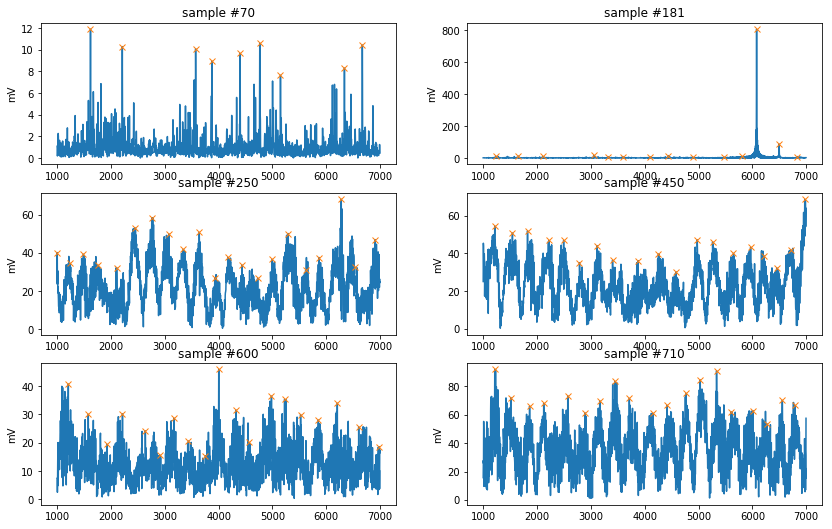

Sample #0, Peak freq: [ 1620.59  2211.76  3573.53  3876.47  4400.    4764.71  5150.  ], median gap523.53
Sample #1, Peak freq: [ 1229.41  1655.88  2105.88  3058.82  3323.53  3602.94  4114.71], median gap426.47
Sample #2, Peak freq: [ 1002.94  1244.12  1488.24  1764.71  2105.88  2441.18  2758.82], median gap317.64
Sample #3, Peak freq: [ 1214.71  1544.12  1823.53  2220.59  2494.12  2788.24  3114.71], median gap294.12
Sample #4, Peak freq: [ 1208.82  1579.41  1929.41  2214.71  2638.24  2905.88  3170.59], median gap285.3
Sample #5, Peak freq: [ 1214.71  1511.76  1861.76  2123.53  2570.59  2891.18  3164.71], median gap297.05


In [371]:
# Envelop spectrum (Hilbert method) of the signal in a range of frequencies on sample
plt.figure()
plt.figure(figsize=(14, 12))
ind = 0
peaks = []

freq_range = [1000, 7000]
# Samples selection
#sample_list = range(0,df.shape[0],int(df.shape[0]/7.9))
sample_list = [70, 181, 250, 450, 600, 710]

for i in sample_list:
    ind += 1

    half = int(len(df[4].iloc[i])/2) # For keeping the positive frequency components 
    epoch = df[4].iloc[i]
    epoch -= baseline # Center the signal to 0
    inf = int(freq_range[0]/float((df[3].iloc[i]/df[1].iloc[i])))
    sup = int(freq_range[1]/float((df[3].iloc[i]/df[1].iloc[i])))
    
    analytic_signal = sg.hilbert(epoch)
    amplitude_envelope = np.abs(analytic_signal)
    
    #indexes = sg.find_peaks_cwt(fft_epoch2, np.arange(1, 10), max_distances=np.arange(1, 10)*2)
    #indexes = np.array(indexes) - 1
    indexes, _ = sg.find_peaks(amplitude_envelope[inf:sup], height = max(5,np.percentile(amplitude_envelope[inf:sup], 60)), distance=80, prominence=0.8)
    peaks.append(indexes)
    
    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.subplot(4,2,ind)
    plt.plot(freq[inf:sup], amplitude_envelope[:half][inf:sup])
    plt.plot(freq[inf:sup][indexes], amplitude_envelope[inf:sup][indexes], "x")
    plt.ylabel('mV')
    plt.title("sample #"+str(i))

plt.show()
for i in range(len(peaks)):
    #peak_i = np.where(peaks[i] == True)
    peak_i = peaks[i]
    #print(i, len(peak_i), np.round(freq[peak_i[0:min(len(peak_i), 8)]],2))
    print('Sample #{}, Peak freq: {}, median gap{}'.format(i, np.round(freq[peak_i[:min(len(peak_i), 7)]]+freq_range[0],2),
                                            np.median(np.diff(np.round(freq[peak_i[0:min(len(peak_i), 8)]],2)))))
    
    

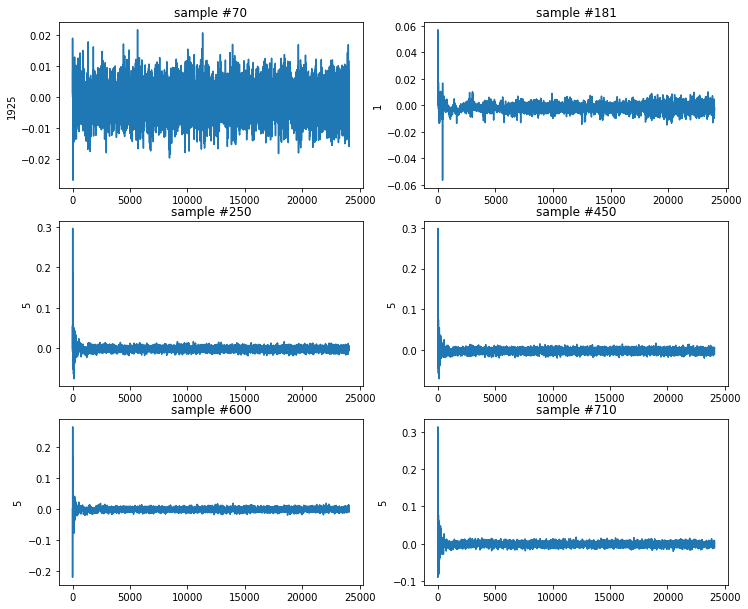

In [373]:
# Cepstrum
plt.figure()
plt.figure(figsize=(12, 14))
ind = 0
peaks = []


# Samples selection
#sample_list = range(0,df.shape[0],int(df.shape[0]/7.9))
sample_list = [70, 181, 250, 450, 600, 710]

for i in sample_list:
    ind += 1
    half = int(len(df[4].iloc[i])/2) # For keeping the positive frequency components 
    epoch = df[4].iloc[i]
    epoch -= np.mean(epoch) # Center the signal to 0
    
    
    #powerspectrum = np.abs(np.fft.fft(epoch2))**2
    spectrum = np.abs(np.fft.fft(epoch))
    #cepstrum = np.fft.ifft(np.log(powerspectrum)).real[:half]
    cepstrum = np.fft.ifft(np.log(spectrum)).real[:half]
    for j in range(1):
        cepstrum[j]=0.0001
    
    #indexes = sg.find_peaks_cwt(fft_epoch2, np.arange(1, 10), max_distances=np.arange(1, 10)*2)
    #indexes = np.array(indexes) - 1
    indexes, _ = sg.find_peaks(cepstrum, height = max(800,np.percentile(cepstrum, 95)), distance=200, prominence=0.9)
    peaks.append(indexes)
    
    # Frequency bins
    freq = np.multiply(float((df[3].iloc[i]/df[1].iloc[i])),range(half))
    
    plt.subplot(4,2,ind)
    plt.plot(freq, cepstrum[:half])
    plt.plot(freq[indexes], cepstrum[indexes], "x")
    plt.ylabel(str(np.argmax(cepstrum)))
    plt.title("sample #"+str(i))

plt.show()
#for i in range(len(peaks)):
    #peak_i = np.where(peaks[i] == True)
    #peak_i = peaks[i]
    #print(np.argmax(cepstrum))
    #print(i, len(peak_i), peak_i[0])
    #print(i, len(peak_i), np.round(freq[peak_i[0:min(len(peak_i), 8)]],2))


This transformation does not provide much information in comparison with the other transformations tested in the current case.